# Conditional GAN MNIST

This notebook is for implementing [Conditional Generative Adversarial Network](https://arxiv.org/abs/1411.1784) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
algorithm = 'CGAN_CNN_MNIST'

img_size   = 28

batch_size = 128
num_epoch  = 50

n_latent = 100
n_condition = 10

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_epoch = 5

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_CGAN_CNN_MNIST/model/model" 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, c, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):       
        x_concat = tf.concat([x, c], -1)
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x_concat.get_shape()[1], 7*7*512])
        b1 = tf.get_variable('b1', [7*7*512])
        
        x_project = tf.matmul(x_concat,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 512))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=256, kernel_size=5, strides=1, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=128, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=64, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME')     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, c, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        
        # Project and Reshape COndition
        wc = tf.get_variable('wc', [c.get_shape()[1], img_size*img_size*n_condition])
        bc = tf.get_variable('bc', [img_size*img_size*n_condition])
        
        c_project = tf.matmul(c,wc)+bc
        c_reshape = tf.reshape(c_project, (-1, img_size, img_size, n_condition))
        
        # Concatenate input and condition
        x_concat = tf.concat([x, c_reshape], -1)
        
        # First conv layer
        h1 = tf.layers.conv2d(x_concat, filters=32, kernel_size=5, strides=2, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=64, kernel_size=5, strides=2, padding='SAME')
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=128, kernel_size=5, strides=2, padding='SAME')
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [8]:
def GAN(x, c, z, is_training):
    # Generator  
    G = Generator(z, c, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, c, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, c, is_training, reuse=True)
    
    # get loss (LSGAN Loss)
    d_loss = tf.reduce_mean(tf.square(D_logit_real-1)) + tf.reduce_mean(tf.square(D_logit_fake))
    g_loss = tf.reduce_mean(tf.square(D_logit_fake-1))

    return d_loss, g_loss, G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

c = tf.placeholder(tf.float32, shape=[None, n_condition])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, c, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [ ]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: 1.05513 / D Loss: 0.02380


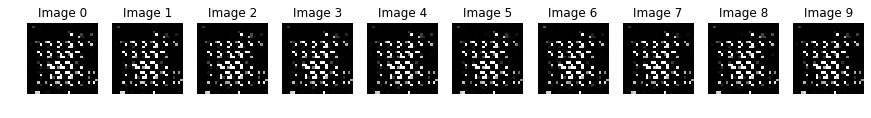

Epoch: 2 / G Loss: 1.16405 / D Loss: 0.04263
Epoch: 3 / G Loss: 0.81373 / D Loss: 0.05923
Epoch: 4 / G Loss: 0.83974 / D Loss: 0.14746
Epoch: 5 / G Loss: 0.81351 / D Loss: 0.22297


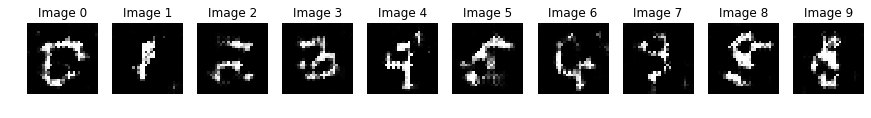

Epoch: 6 / G Loss: 0.72826 / D Loss: 0.15736
Epoch: 7 / G Loss: 0.49545 / D Loss: 0.33674
Epoch: 8 / G Loss: 0.65492 / D Loss: 0.17035
Epoch: 9 / G Loss: 0.76777 / D Loss: 0.15375
Epoch: 10 / G Loss: 0.74535 / D Loss: 0.20468


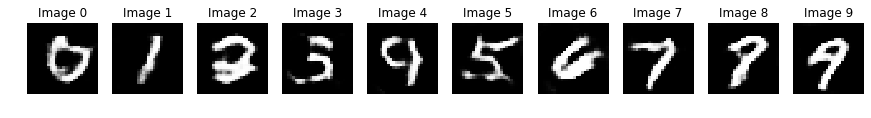

Epoch: 11 / G Loss: 0.47174 / D Loss: 0.27789
Epoch: 12 / G Loss: 0.70180 / D Loss: 0.27045
Epoch: 13 / G Loss: 0.76561 / D Loss: 0.22766
Epoch: 14 / G Loss: 0.63893 / D Loss: 0.42694
Epoch: 15 / G Loss: 0.84151 / D Loss: 0.26081


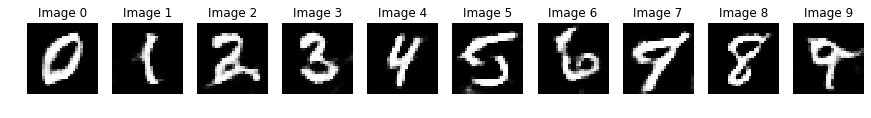

Epoch: 16 / G Loss: 0.46717 / D Loss: 0.55954
Epoch: 17 / G Loss: 0.46673 / D Loss: 0.50547
Epoch: 18 / G Loss: 0.58123 / D Loss: 0.34161
Epoch: 19 / G Loss: 0.51018 / D Loss: 0.61589
Epoch: 20 / G Loss: 0.69950 / D Loss: 0.28112


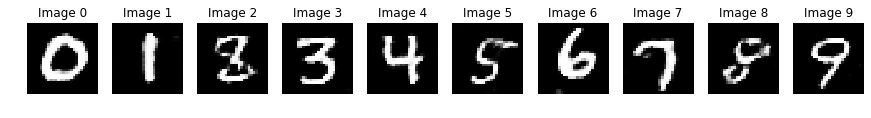

Epoch: 21 / G Loss: 0.46406 / D Loss: 0.39762
Epoch: 22 / G Loss: 0.45470 / D Loss: 0.31409
Epoch: 23 / G Loss: 0.76074 / D Loss: 0.26975
Epoch: 24 / G Loss: 0.35501 / D Loss: 0.57112
Epoch: 25 / G Loss: 0.67981 / D Loss: 0.38478


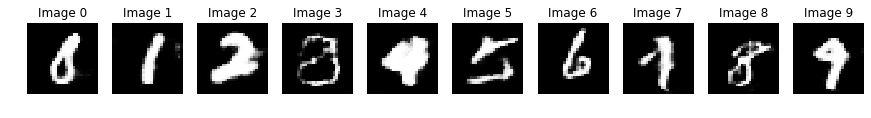

Epoch: 26 / G Loss: 0.47788 / D Loss: 0.40791
Epoch: 27 / G Loss: 0.46419 / D Loss: 0.43300
Epoch: 28 / G Loss: 0.73138 / D Loss: 0.28534
Epoch: 29 / G Loss: 0.56813 / D Loss: 0.39528
Epoch: 30 / G Loss: 0.50634 / D Loss: 0.39473


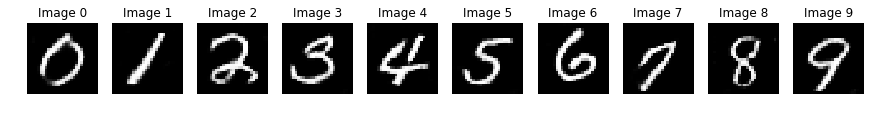

Epoch: 31 / G Loss: 0.48845 / D Loss: 0.41610
Epoch: 32 / G Loss: 0.47850 / D Loss: 0.22007
Epoch: 33 / G Loss: 0.35891 / D Loss: 0.45174
Epoch: 34 / G Loss: 0.36142 / D Loss: 0.40162
Epoch: 35 / G Loss: 0.67874 / D Loss: 0.30714


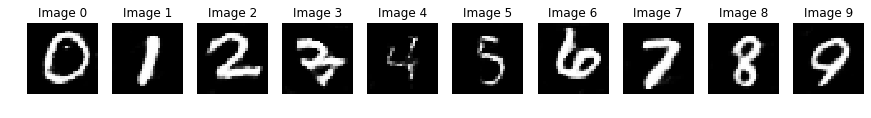

Epoch: 36 / G Loss: 0.40660 / D Loss: 0.38805
Epoch: 37 / G Loss: 0.55352 / D Loss: 0.35682
Epoch: 38 / G Loss: 0.44053 / D Loss: 0.56138
Epoch: 39 / G Loss: 0.37287 / D Loss: 0.29508
Epoch: 40 / G Loss: 0.61238 / D Loss: 0.42195


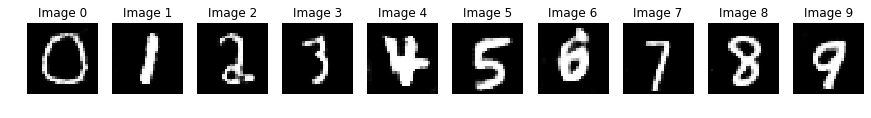

Epoch: 41 / G Loss: 0.56042 / D Loss: 0.41036
Epoch: 42 / G Loss: 0.38066 / D Loss: 0.51969
Epoch: 43 / G Loss: 0.60213 / D Loss: 0.39798
Epoch: 44 / G Loss: 0.52049 / D Loss: 0.36702
Epoch: 45 / G Loss: 0.38447 / D Loss: 0.38096


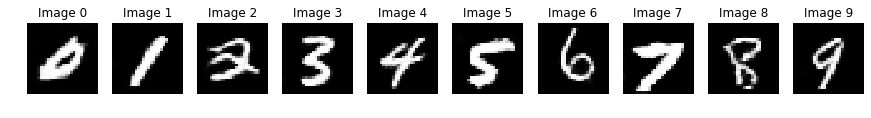

Epoch: 46 / G Loss: 0.39159 / D Loss: 0.29713
Epoch: 47 / G Loss: 0.51637 / D Loss: 0.32010
Epoch: 48 / G Loss: 0.81680 / D Loss: 0.28948
Epoch: 49 / G Loss: 0.34372 / D Loss: 0.39673
Epoch: 50 / G Loss: 0.32696 / D Loss: 0.35443


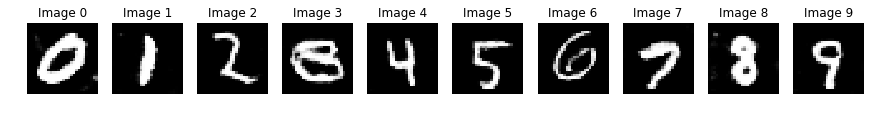

In [11]:
if train_model:
    # Training
    len_data = x_train.shape[0]

    for i in range(num_epoch):
        # Shuffle the data 
        random_idx = np.arange(len_data)
        np.random.shuffle(random_idx)

        # Making mini-batch
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                batch_index = [j, j + batch_size]

                data_x_in  = x_train[random_idx[batch_index[0]:batch_index[1]],:,:]
                data_y_val = y_train[random_idx[batch_index[0]:batch_index[1]]]
            else:
                batch_index = [j, j + len_data-1]

                data_x_in  = x_train[random_idx[batch_index[0]:batch_index[-1]],:,:]
                data_y_val = y_train[random_idx[batch_index[0]:batch_index[-1]]]

            data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))
            data_y_in = np.zeros([data_x_in.shape[0], n_condition])

            # Make one hot 
            for k in range(len(data_y_val)):
                data_y_in[k,data_y_val[k]] = 1

            # Get sample z
            sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))

            # Run Optimizer!
            _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, c: data_y_in, z: sampled_z, is_training: True})
            _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, c: data_y_in, z: sampled_z, is_training: True})

            print("Batch: {} / {}".format(j, len_data), end="\r")

        # Print Progess
        print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

        # Show test images 
        n_test = 10

        z_test = np.random.uniform(-1, 1, size=(n_test, n_latent))
        c_test = np.zeros([n_test,n_condition])

        for j in range(n_test):
            c_test[j,j] = 1

        G_out = sess.run(G, feed_dict = {z: z_test,c: c_test, is_training: False})

        if i == 0 or (i+1) % show_result_epoch == 0:
            f, ax = plt.subplots(1,n_test, figsize=(15,15))
            for j in range(n_test):
                ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

        plt.show()

## Image Generation

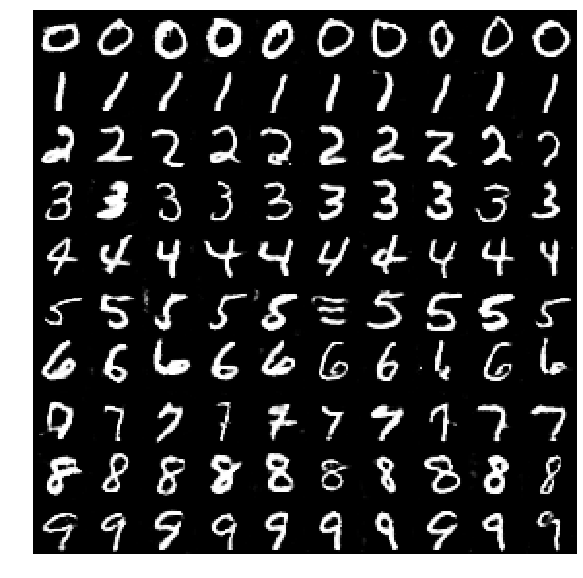

In [14]:
num_test = 10
   
img = np.zeros([img_size * num_test, img_size * num_test])

for i in range(num_test):
    for j in range(num_test):        
        c_result = np.zeros([1,n_condition])
        c_result[0, i] = 1
        
        z_result = np.random.uniform(-1, 1, size=(1, n_latent))
        
        G_result = sess.run(G, feed_dict = {z: z_result, c: c_result, is_training: False})
                
        img[i * img_size : (i + 1) * img_size, (j) * img_size : (j + 1) * img_size] = G_result[:,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))